This notebook explores historical 1-bedroom median rents in major U.S. cities using Zillow’s public dataset. I wanted to understand how affordability has shifted over time, and this notebook is the first step: loading and transforming raw rent data.

## 1. Gather data

First I'm going to download the raw data for the Zillow Observed Rent Index for the cities I'm interested in. I'm looking for city rent data over time, so I want something longitudinal. I spent some time looking for a good dataset, and Zillow's ZORI seems like the best bet. This is how Zillow itself describes it:

_**Zillow Observed Rent Index (ZORI)**: A smoothed measure of the typical observed market rate rent across a given region. ZORI is a repeat-rent index that is weighted to the rental housing stock to ensure representativeness across the entire market, not just those homes currently listed for-rent. The index is dollar-denominated by computing the mean of listed rents that fall into the 35th to 65th percentile range for all homes and apartments in a given region, which is weighted to reflect the rental housing stock._

This includes both single-family and multi-family homes.

From there, I'll import the tools needed:

In [1]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
import cpi

In [2]:
# Read in the CSV file
df = pd.read_csv('City_zori_uc_sfrcondomfr_sm_month.csv')

# Display basic information about the dataframe
print("DataFrame Info:")
print(df.info())

# Show the first few rows
print("\nFirst few rows:")
print(df.head())

# Display column names
print("\nColumn names:")
print(df.columns.tolist())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3307 entries, 0 to 3306
Columns: 130 entries, RegionID to 2025-02-28
dtypes: float64(122), int64(2), object(6)
memory usage: 3.3+ MB
None

First few rows:
   RegionID  SizeRank   RegionName RegionType StateName State  \
0      6181         0     New York       city        NY    NY   
1     12447         1  Los Angeles       city        CA    CA   
2     39051         2      Houston       city        TX    TX   
3     17426         3      Chicago       city        IL    IL   
4      6915         4  San Antonio       city        TX    TX   

                                   Metro          CountyName   2015-01-31  \
0  New York-Newark-Jersey City, NY-NJ-PA       Queens County  2519.633872   
1     Los Angeles-Long Beach-Anaheim, CA  Los Angeles County  1829.491393   
2   Houston-The Woodlands-Sugar Land, TX       Harris County  1192.772833   
3     Chicago-Naperville-Elgin, IL-IN-WI         Cook County  1525.898035   
4  

So we can tell that the data is
- One row per city (perfect)
- Includes the metro area, state, county etc (not really  necessary)
- And the observed rent (the mean of the 35th to 65th percentile, per Zillow).

Great! 

## 2. Clean up data

Now the real work begins...

Next I want to isolate only the cities I particularly care about for this analysis. For this purpose, that's cities I've lived in:
- Dallas, TX
- Cambridge, MA
- Brooklyn, NY
- Oakland, CA
- San Francisco, CA

... and cities where I'm curious about tracking their affordability over time, since I'm curious how the pandemic and remote work boom has affected them:
- Portland, OR
- Seattle, WA
- Miami, FL

Let's isolate that data now. I have a feeling the data won't be as neatly set up as I hope, but first pass:



In [11]:
# Filter for specific cities of interest
cities_of_interest = ['New York','Brooklyn', 'Dallas', 'Cambridge', 'Oakland', 'San Francisco', 'Portland', 'Seattle', 'Miami']
narrowed_df = df[df['RegionName'].isin(cities_of_interest)]

# Display the filtered dataframe
print("Filtered DataFrame:")
print(narrowed_df)


Filtered DataFrame:
      RegionID  SizeRank     RegionName RegionType StateName State  \
0         6181         0       New York       city        NY    NY   
9        38128         9         Dallas       city        TX    TX   
17       20330        17  San Francisco       city        CA    CA   
20       12700        20          Miami       city        FL    FL   
24       16037        24        Seattle       city        WA    WA   
25       13373        25       Portland       city        OR    OR   
51       13072        51        Oakland       city        CA    CA   
355       3934       360      Cambridge       city        MA    MA   
521      24307       526         Dallas       city        GA    GA   
795      40415       808       Portland       city        ME    ME   
2191     51636      2699         Dallas       city        OR    OR   
2591      6584      3611       Portland       city        TX    TX   
2969     13076      5333        Oakland       city        TN    TN   


A few findings:
- A few extra cities are included in the data that need to be excluded.
- NYC doesn't split out into the county level data that includes Brooklyn. (Right?)

Let's investigate:

In [4]:
# Look at all regions in the NYC metro area and see if you can narrow down.
nyc_regions = df[df['Metro'] == 'New York-Newark-Jersey City, NY-NJ-PA'][['RegionName', 'State', 'CountyName']]
nyc=nyc_regions[nyc_regions['CountyName'].isin(['New York County', 'Kings County', 'Queens County', 'Bronx County', 'Richmond County'])]
print("\nNYC metro area cities in the dataset:")
print(nyc)


NYC metro area cities in the dataset:
  RegionName State     CountyName
0   New York    NY  Queens County


Bummer. OK, we'll leave that in. Now removing the extra data we don't need, and looking at the result:

In [13]:

# Also, create some states we're not interested in and filter the dataset.
states_to_exclude = ['TN', 'GA', 'ME']
counties_to_exclude = ['San Patricio County'] # removing the extra corpus christi data
filtered_df = narrowed_df[~narrowed_df['State'].isin(states_to_exclude)]
filtered_df = filtered_df[~filtered_df['CountyName'].isin(counties_to_exclude)]
# Also remove the extra data where state = OR *and* city = Dallas; that's just confuisng the data!
filtered_df = filtered_df[~((filtered_df['State'] == 'OR') & (filtered_df['RegionName'] == 'Dallas'))]
# Display the filtered dataframe
print("\nFiltered DataFrame:")
print(filtered_df)


Filtered DataFrame:
     RegionID  SizeRank     RegionName RegionType StateName State  \
0        6181         0       New York       city        NY    NY   
9       38128         9         Dallas       city        TX    TX   
17      20330        17  San Francisco       city        CA    CA   
20      12700        20          Miami       city        FL    FL   
24      16037        24        Seattle       city        WA    WA   
25      13373        25       Portland       city        OR    OR   
51      13072        51        Oakland       city        CA    CA   
355      3934       360      Cambridge       city        MA    MA   

                                       Metro            CountyName  \
0      New York-Newark-Jersey City, NY-NJ-PA         Queens County   
9            Dallas-Fort Worth-Arlington, TX         Dallas County   
17        San Francisco-Oakland-Berkeley, CA  San Francisco County   
20   Miami-Fort Lauderdale-Pompano Beach, FL     Miami-Dade County   
24     

Perfect. Next we need to `melt` the data-- get one row per observation (long) rather than the current format (wide), which annoyingly has months in the coolumns. In this case, we want to:
- Keep certain columns as identifiers (RegionName, State, Metro, etc.)
- Melt all the date columns into two new columns:
-- One for the date
-- One for the rent value


In [14]:
# Keep these columns as identifiers
id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 
           'State', 'Metro', 'CountyName']

# Melt the dataframe
melted_df = pd.melt(filtered_df, 
                   id_vars=id_vars,
                   var_name='Date',  # This will be the new column for dates
                   value_name='Rent')  # This will be the new column for rent values

# Let's take a look.
melted_df.head(10)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,Date,Rent
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2015-01-31,2519.633872
1,38128,9,Dallas,city,TX,TX,"Dallas-Fort Worth-Arlington, TX",Dallas County,2015-01-31,1074.757370
2,20330,17,San Francisco,city,CA,CA,"San Francisco-Oakland-Berkeley, CA",San Francisco County,2015-01-31,2991.486666
3,12700,20,Miami,city,FL,FL,"Miami-Fort Lauderdale-Pompano Beach, FL",Miami-Dade County,2015-01-31,1696.931325
4,16037,24,Seattle,city,WA,WA,"Seattle-Tacoma-Bellevue, WA",King County,2015-01-31,1543.150935
5,13373,25,Portland,city,OR,OR,"Portland-Vancouver-Hillsboro, OR-WA",Multnomah County,2015-01-31,1181.526835
6,13072,51,Oakland,city,CA,CA,"San Francisco-Oakland-Berkeley, CA",Alameda County,2015-01-31,1786.294639
7,3934,360,Cambridge,city,MA,MA,"Boston-Cambridge-Newton, MA-NH",Middlesex County,2015-01-31,2353.489078
8,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2015-02-28,2532.526220
9,38128,9,Dallas,city,TX,TX,"Dallas-Fort Worth-Arlington, TX",Dallas County,2015-02-28,1077.021337


Looking good! The data looks like it's in the right format and correct timeframe (10 years or so).

## 3. Visualize data

Now that things look cleaner, I'd like to see the data graphed. For this I'll use `seaborn` since it's easier syntax and prettier than just `matplotlib`, and more widely supported than `plotly`, another favorite of mine in the past.

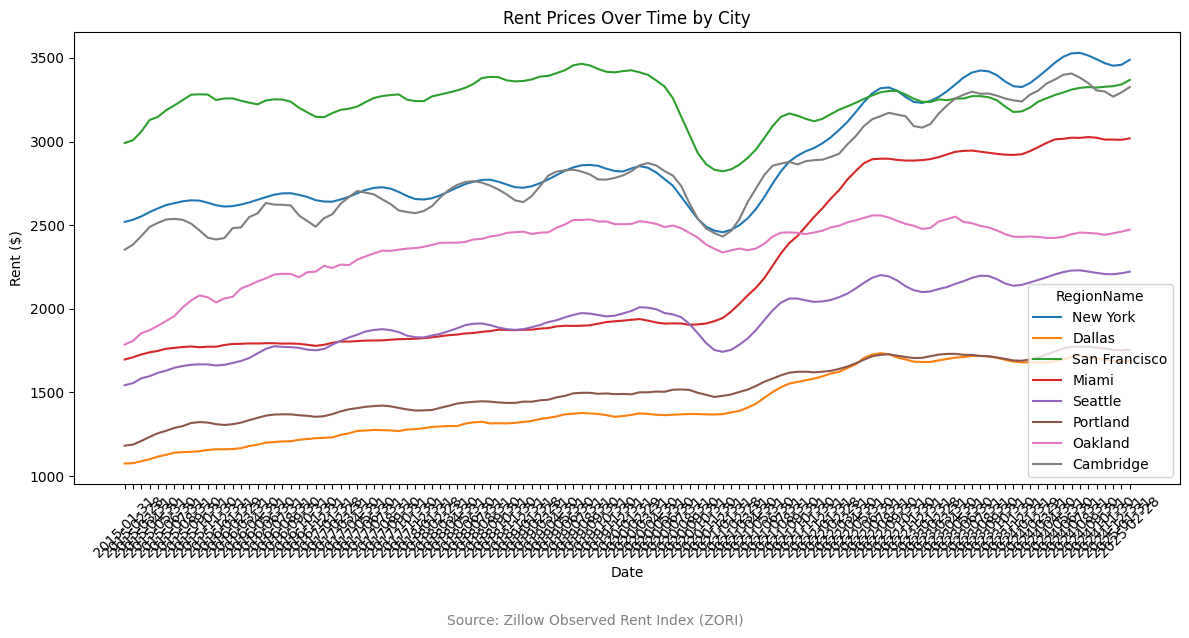

In [15]:
# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df, x='Date', y='Rent', hue='RegionName')

# Customize the plot
plt.title('Rent Prices Over Time by City')
plt.xticks(rotation=45)
plt.ylabel('Rent ($)')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add footer
plt.figtext(0.5, -0.05, "Source: Zillow Observed Rent Index (ZORI)", ha="center", fontsize=10, color="gray")

# Show the plot
plt.show()


Great -- and I can already start to see some of the trends that I want to see. But clearly the viz needs a lot of cleanup! I'm going to take another pass, and in doing so:
- I'd like to include labels at the beginnings and ends of the dataviz, a trick I learned from _Storytelling With Data_ by Cole Nussbaumer Knaflic.
- The X axis I'll simplify to just years; the Y axis I'll remove entirely, since I think it will be easier to comprehend data labels than referring to an axis.
- ...and a million other tiny tweaks.

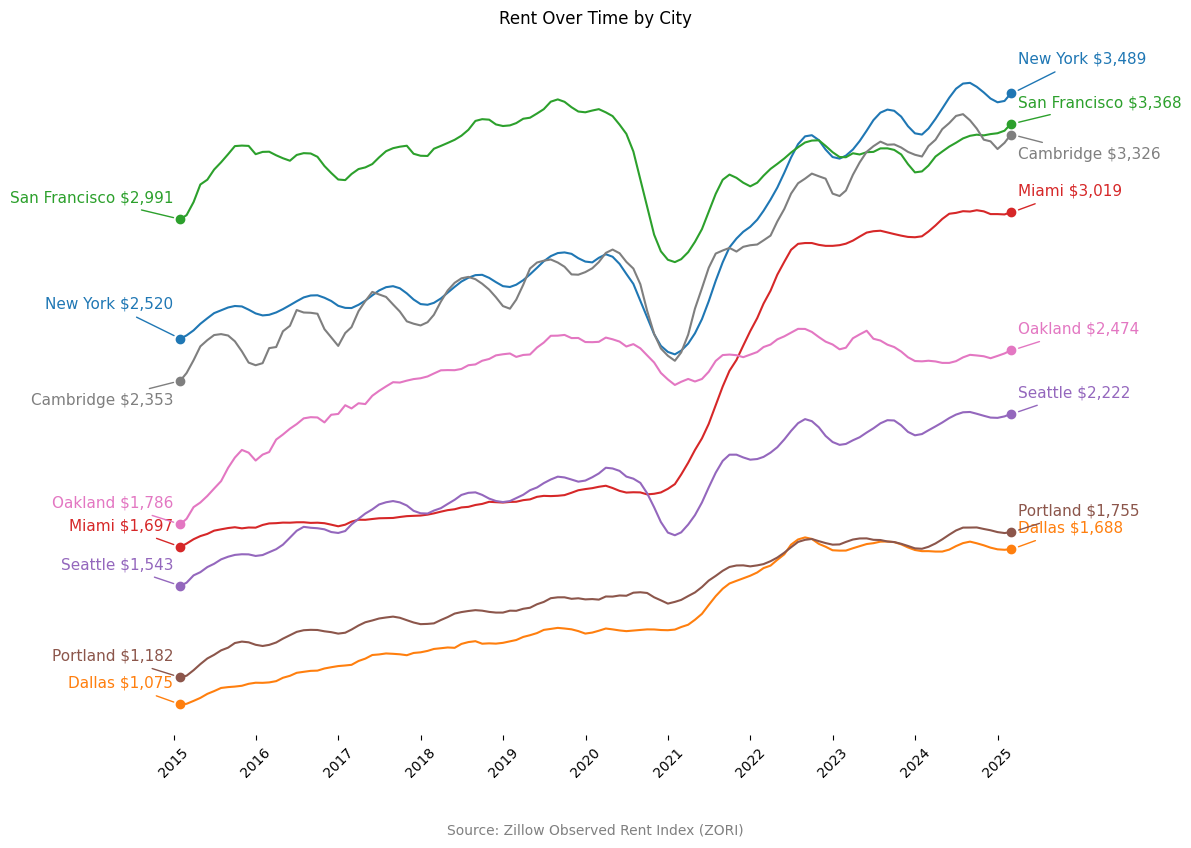

In [16]:
# First melt the data
id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 
           'State', 'Metro', 'CountyName']
melted_df = pd.melt(filtered_df, 
                   id_vars=id_vars,
                   var_name='Date',
                   value_name='Rent')

# Convert Date column to datetime
melted_df['Date'] = pd.to_datetime(melted_df['Date'])

# Create the plot
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=melted_df, x='Date', y='Rent', hue='RegionName', legend=False)

# Remove the border and y-axis labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylabel('')  # Remove y-axis label
ax.set_yticklabels([])  # Remove y-axis tick labels

# Format x-axis to show only yearly ticks
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# Rotate x-axis labels
plt.xticks(rotation=45)

# Get min and max dates
min_date = melted_df['Date'].min()
max_date = melted_df['Date'].max()

# Calculate y-axis range for dynamic spacing
y_min, y_max = ax.get_ylim()
y_range = y_max - y_min

# Add labels and dots for each line
for i, line in enumerate(ax.lines):
    # Get the data for this line
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    
    # Get the city name from the dataframe
    city = melted_df['RegionName'].unique()[i]
    
    # Add dots at start and end
    plt.plot(x_data[0], y_data[0], 'o', color=line.get_color())
    plt.plot(x_data[-1], y_data[-1], 'o', color=line.get_color())
    
    # Calculate dynamic offsets based on city to prevent overlap
    offset_multiplier = 1.0
    if city == 'San Francisco':
        offset_multiplier = 1
    elif city == 'Cambridge':
        offset_multiplier = -2
    elif city == 'New York':
        offset_multiplier = 2
    
    # Start label
    label_text = f'{city} ${y_data[0]:,.0f}'
    plt.annotate(label_text,
                xy=(x_data[0], y_data[0]),
                xytext=(x_data[0] - 30, y_data[0] + (0.02 * y_range * offset_multiplier)),
                color=line.get_color(),
                ha='right',
                va='bottom',
                fontsize=11,
                  arrowprops=dict(
      arrowstyle='-',
      color=line.get_color(),
      lw=1,
      shrinkA=5,  # pixels to shrink from the start (dot)
      shrinkB=5,  # pixels to shrink from the end (label)
  ))
    
    # End label
    label_text = f'{city} ${y_data[-1]:,.0f}'
    if city == 'Cambridge':
        va = 'top'
        y_offset = -0.04 * y_range * 2 
    elif city == 'San Francisco':
        va = 'top'
        y_offset = -0.04 * y_range * 3
    else:
        va = 'bottom'
        y_offset = 0.02 * y_range
    plt.annotate(label_text,
                xy=(x_data[-1] + 5, y_data[-1]),
                xytext=(x_data[-1] + 30, y_data[-1] + (0.02 * y_range * offset_multiplier)),
                color=line.get_color(),
                ha='left',
                va='bottom',
                fontsize=11,
                  arrowprops=dict(
                        arrowstyle='-',
                        color=line.get_color(),
                        lw=1,
                        shrinkA=5,  # pixels to shrink from the start (dot)
                        shrinkB=5,  # pixels to shrink from the end (label)
                    ))

# Add title and adjust layout
plt.title('Rent Over Time by City', pad=20)
ax.set_yticks([]) #remove y-axis labels
ax.set_xlabel('') #remove x-axis labels
plt.figtext(0.5, -0.05, "Source: Zillow Observed Rent Index (ZORI)", ha="center", fontsize=10, color="gray") #add footer
plt.tight_layout()

# Show the plot
plt.show()

This is great -- we can see how New York has now edged up well over SF, while Miami, which used to hover near Oakland and Seattle, now is almost as expensive as Cambridge and SF (!). 

But now, I'm also curious if there's a relatively easy way to take a dataset like this and adjust for inflation. Right now I'm just looking at nominal  rents, but I'm curious if they've actually gone down. Fortunately there's a package for that too (`cpi`) that makes things _very_ easy.

## 4. Adjust for inflation and re-plot

I'm going to take our `melted_df` data from earlier  and create inflation-adjusted data. It only works by year, so it'll be a bit approximate, but it'll be interesting to see how things evolved.

In [24]:
inflation_adjusted_df = melted_df.copy()
inflation_adjusted_df['year'] = inflation_adjusted_df['Date'].dt.year #extract year from date since inflation with this package only works by year
target_column='Rent' # our rent column we're looking at
# There's only data up until 2024, so we'll use that as the reference year.
max_supported_year = 2024

# Turns out we also have to remove 2025 data since it's not supported.
inflation_adjusted_df = inflation_adjusted_df[inflation_adjusted_df['year'] < 2025]

# Create a new column for the inflation-adjusted rent

inflation_adjusted_df['infl_adjusted_rent'] = inflation_adjusted_df.apply(
    lambda row: cpi.inflate(row[target_column], row['year'], to=max_supported_year),
    axis=1
)


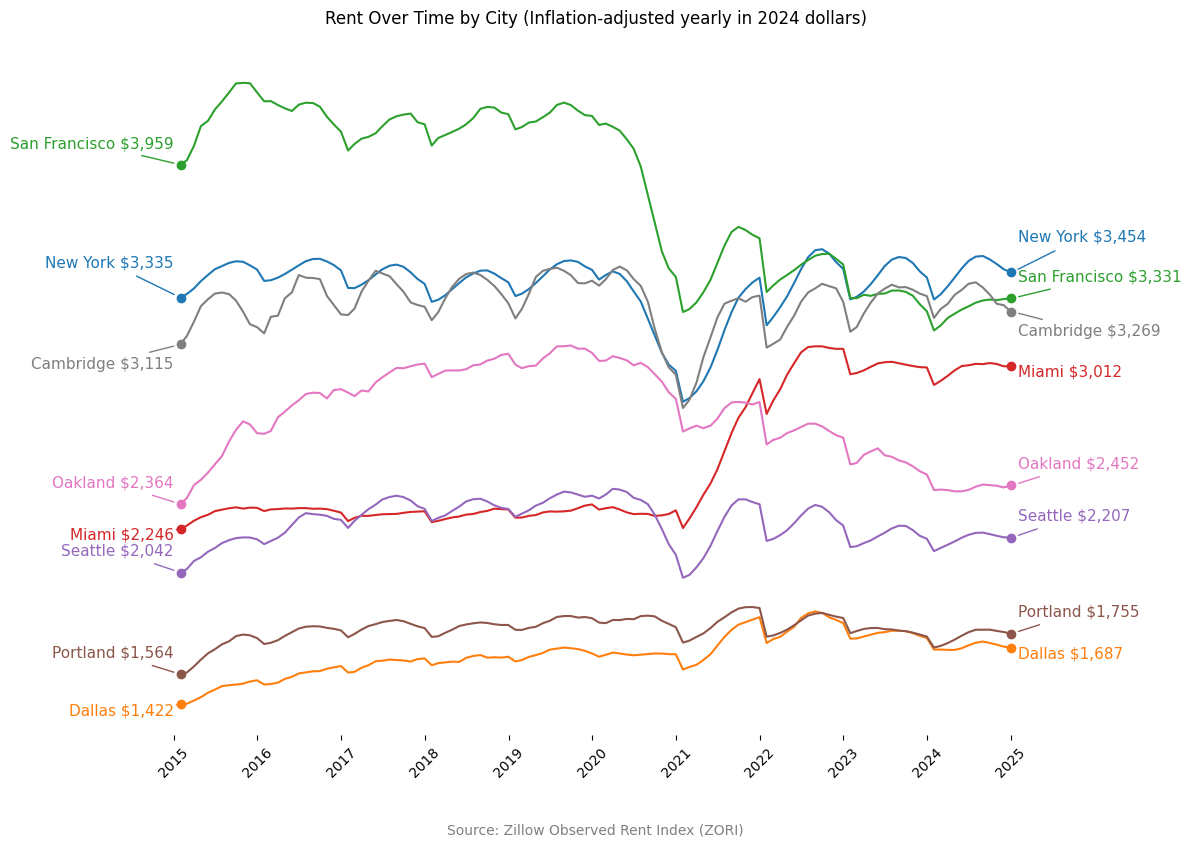

In [31]:

# Now that I have the inflation-adjusted data, I can plot it.

# Create the plot
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=inflation_adjusted_df, x='Date', y='infl_adjusted_rent', hue='RegionName', legend=False)

# Remove the border and y-axis labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylabel('')  # Remove y-axis label
ax.set_yticklabels([])  # Remove y-axis tick labels

# Format x-axis to show only yearly ticks
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# Rotate x-axis labels
plt.xticks(rotation=45)

# Get min and max dates
min_date = inflation_adjusted_df['Date'].min()
max_date = inflation_adjusted_df['Date'].max()

# Calculate y-axis range for dynamic spacing
y_min, y_max = ax.get_ylim()
y_range = y_max - y_min

# Add labels and dots for each line
for i, line in enumerate(ax.lines):
    # Get the data for this line
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    
    # Get the city name from the dataframe
    city = inflation_adjusted_df['RegionName'].unique()[i]
    
    # Add dots at start and end
    plt.plot(x_data[0], y_data[0], 'o', color=line.get_color())
    plt.plot(x_data[-1], y_data[-1], 'o', color=line.get_color())
    
    # Calculate dynamic offsets based on city to prevent overlap
    offset_multiplier = 1.0
    if city == 'San Francisco':
        offset_multiplier = 1
    elif city == 'Cambridge':
        offset_multiplier = -2
    elif city == 'New York':
        offset_multiplier = 2
    elif city == 'Miami':
        offset_multiplier=-1
    elif city == 'Dallas':
        offset_multiplier=-1
    
    # Start label
    label_text = f'{city} ${y_data[0]:,.0f}'
    plt.annotate(label_text,
                xy=(x_data[0], y_data[0]),
                xytext=(x_data[0] - 30, y_data[0] + (0.02 * y_range * offset_multiplier)),
                color=line.get_color(),
                ha='right',
                va='bottom',
                fontsize=11,
                  arrowprops=dict(
      arrowstyle='-',
      color=line.get_color(),
      lw=1,
      shrinkA=5,  # pixels to shrink from the start (dot)
      shrinkB=5,  # pixels to shrink from the end (label)
  ))
    
    # End label
    label_text = f'{city} ${y_data[-1]:,.0f}'
    if city == 'Cambridge':
        va = 'top'
        y_offset = -0.04 * y_range * 2 
    elif city == 'San Francisco':
        va = 'top'
        y_offset = -0.04 * y_range * 3
    else:
        va = 'bottom'
        y_offset = 0.02 * y_range
    plt.annotate(label_text,
                xy=(x_data[-1] + 5, y_data[-1]),
                xytext=(x_data[-1] + 30, y_data[-1] + (0.02 * y_range * offset_multiplier)),
                color=line.get_color(),
                ha='left',
                va='bottom',
                fontsize=11,
                  arrowprops=dict(
                        arrowstyle='-',
                        color=line.get_color(),
                        lw=1,
                        shrinkA=5,  # pixels to shrink from the start (dot)
                        shrinkB=5,  # pixels to shrink from the end (label)
                    ))

# Add title and adjust layout
plt.title('Rent Over Time by City (Inflation-adjusted yearly in 2024 dollars)', pad=20)
ax.set_yticks([]) #remove y-axis labels
ax.set_xlabel('') #remove x-axis labels
plt.figtext(0.5, -0.05, "Source: Zillow Observed Rent Index (ZORI)", ha="center", fontsize=10, color="gray") #add footer
plt.tight_layout()

# Show the plot
plt.show()



This shows a pretty fascinating post-COVID adjustment beyond what we usually assume or see in the headlines -- and finally gives me the chart I've had in my mind's eye this entire time. Satisfying.

## 5. Conclusions  and next steps

**Some takeaways**
- With the inflation-adjusted ZORI taken into consideration we can see how in many ways San Francisco has cratered, Miami has boomed, and Oakland boomed and then busted.
- COVID made all of the rents crash in 2020, but by the end of 2021 things were, for most cities that aren't Miami and SF, "back to normal" (more or less) when adjusted for inflation.
- Surprisingly, most other cities in my index haven't actually changed that much in terms of their inflation-rent. This was quite surprising to me, especially since boomtowns like Dallas I would associate more with Miami (which has skyrocketed) rather than with HCOL West Coast cities like Oakland and Portland.

**Data limitations I'm aware of**
- ZORI is great but there's a lot of ways to measure rents, none of which are perfect.
- CPI uses national figures, not local inflation rates.
- Not all city boundaries are created equal; the city of Dallas includes many square miles of low-cost suburbia, while San Fransico is a small and dense urban center.

**Things I'd love to do in the future**
- Adjust each monthly data point by monthly CPI rather than the noise of yearly; this is mostly just a more complex equation but what we see here gets me 99% of the information I was curious about.
- It would be fascinating to see things adjusted by median or average square footage of rental properties, to get a bit more of a sense of what your price per square foot is. I'd hypothesize we'd see Seattle and Dallas even lower while SF, NYC, and Cambridge would pop even more.
- Tying into median income data for metro areas or cities could give us a better sense of rent burden rather than just absolute observed rents.

Thanks for reading!